<a href="https://colab.research.google.com/github/juliosdutra/Controle_de_Processos_UFES/blob/main/Miscellaneous/HEAT_COND_09dez24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Julio Dutra

-- em 9 de dezembro de 2024

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [226]:
# Dados de entrada - Barra fina com dois materiais
L = 0.05  # Comprimento total da barra (m)
N = 20    # Número total de pontos de discretização

# Geração da malha para o eixo x
# O primeiro material ocupa a metade inicial da barra, e o segundo material ocupa a metade final.
x = np.concatenate([
    np.linspace(0, L/2, int(np.ceil(N/2))), # Posição dos pontos no material 1
    np.linspace(L/2, L, int(np.ceil(N/2)))  # Posição dos pontos no material 2
])

# Espaçamento médio entre os pontos de discretização (supondo espaçamento uniforme no total)
deltaX = L / (N-1)

# Número de pontos em cada material
N1 = int(np.ceil(N/2))  # Número de pontos no material 1
N2 = N - N1             # Número de pontos no material 2 (complemento)

# Exibe o número de pontos em cada material
print(f'N1={N1}, N2={N2}')

# Exibe as posições de todos os pontos de
print('Ponto de discretização\n',x, x.shape)

# Exibe as posições correspondentes à interface entre os dois materiais
print(f'Interface do material 1 em: {x[N1-1]}') # Último ponto no material 1
print(f'Interface do material 1 em: {x[N1]}')   # Primeiro ponto no material 2

N1=10, N2=10
Ponto de discretização
 [0.         0.00277778 0.00555556 0.00833333 0.01111111 0.01388889
 0.01666667 0.01944444 0.02222222 0.025      0.025      0.02777778
 0.03055556 0.03333333 0.03611111 0.03888889 0.04166667 0.04444444
 0.04722222 0.05      ] (20,)
Interface do material 1 em: 0.025
Interface do material 1 em: 0.025


In [281]:
# Temperatura inicial
T_init = 25.0 + 273.15

# Condições nas fronteiras externas
T_i = 30.0 + 273.15
T_f = 25.0 + 273.15

# Parâmetros termofísicos
# Difusividade (alpha)
# Difusividade térmica do nylon: 1.26e-6
# Difusividade térmica do isopor: 4e-7
# Difusividade térmica do latão: 3.39e-5
alfa1 = 1.26e-6
alfa2 = 4e-7

# Coeficiente de condutividade (kappa)
# Coeficiente de condutividade térmica do nylon: 0.24
# Coeficiente de condutividade térmica do isopor: 0.027
# Coeficiente de condutividade térmica do latão: 110.0
kappa1 = 0.24
kappa2 = 0.027

# Condutância térmica na interface de contato
hc = 1e-4
# hc = 1e3

In [282]:
def modelo(t,T):

  # Inicia as derivadas
  dT = np.zeros_like(x)  # Inclui as fontreias do sistema

  # CC em x=0
  dT[0] = 0

  # Pontos centrais da placa 1
  for i in range(1,N1-1):
    dT[i] = alfa1 * (T[i + 1] - 2 * T[i] + T[i - 1]) / (deltaX ** 2)

  # CC em x = L1 para a placa 1
  i = N1-1
  T_aux1 = T[N1-2] - (2*deltaX*hc/kappa1)*(T[N1-1]-T[N1])
  dT[i] = alfa1 * ((T_aux1 - 2 * T[i] + T[i - 1]) / (deltaX ** 2))

  # CC em x = L1 para a placa 2
  i = N1
  T_aux2 = T[N1+1] + (2*deltaX*hc/kappa2)*(T[N1-1]-T[N1])
  dT[i] = alfa2*(T[i+1] - 2 * T[i] + T_aux2)/ (deltaX ** 2)

  # Pontos centrais da placa 2
  for i in range(N1+1,N-1):
    dT[i] = alfa2 * (T[i + 1] - 2 * T[i] + T[i - 1]) / (deltaX ** 2)

  # CC em x=L
  dT[-1] = 0

  return dT

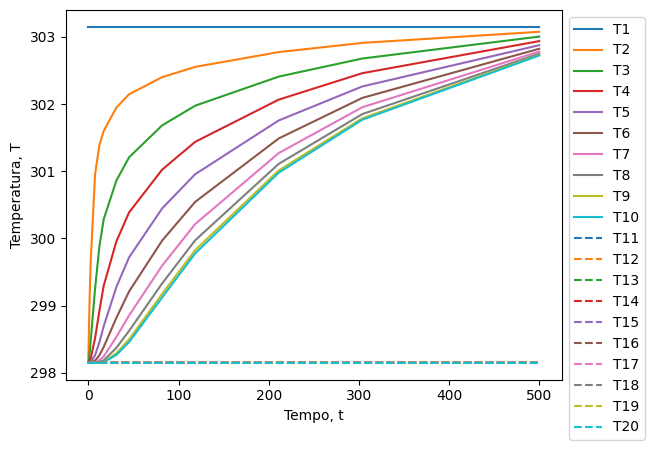

In [283]:
T0 = T_init * np.ones(N)
T0[0] = T_i
T0[-1] = T_f
tspan = [0,500]
sol = solve_ivp(modelo, tspan, T0, method='BDF')

for i, y in enumerate(sol.y):
    linha = '-' if i < N1 else '--'
    plt.plot(sol.t, y, linha, label=f'T{i + 1}')  # Rótulos como T1, T2, ...

plt.xlabel('Tempo, t')
plt.ylabel('Temperatura, T')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [286]:
import plotly.graph_objects as go

# Seleciona um instante específico de tempo (exemplo: último instante de tempo)
tempo_final = sol.t[-1]
temperaturas_finais = sol.y[:, -1]

fig = go.Figure()

fig.add_vrect(x0=0, x1=L/2, line_width=0, fillcolor="red", opacity=0.2,
              annotation_text="Material 1",
              annotation_position="top right",
              annotation_font_size=20,
              annotation_font_color="black"
             )

fig.add_vrect(x0=L/2, x1=L, line_width=0, fillcolor="red", opacity=0.0,
              annotation_text="Material 2",
              annotation_position="top right",
              annotation_font_size=20,
              annotation_font_color="black"
             )

fig.add_vline(x=L/2, line_width=3, line_dash="dash", line_color="grey",
              annotation_text="Interface",
              annotation_position="bottom right",
              annotation_font_size=20,
              annotation_font_color="blue"
             )

fig.add_trace(go.Scatter(x=x, y=temperaturas_finais, mode='lines+markers', name=f't={tempo_final:.2f}s'))

fig.update_layout(
    title='Perfil de Temperatura ao Longo da Barra',
    xaxis_title='Posição (x) [m]',
    yaxis_title='Temperatura (T) [K]',
    # template='plotly_dark'
)
fig.show()


In [285]:
import plotly.graph_objects as go
import numpy as np

# Prepara os dados para o gráfico 3D
X, T = np.meshgrid(x, sol.t)  # Malha no espaço (x) e tempo (t)
Y = sol.y.T  # Transpõe a matriz de solução para combinar com a malha

# Cria o gráfico 3D
fig = go.Figure(data=[go.Surface(
    z=Y,  # Temperatura
    x=T,  # Tempo
    y=X,  # Posição ao longo da barra
    colorscale='Viridis',
    colorbar=dict(title='Temperatura [K]')
)])

# Configurações do layout
fig.update_layout(
    title='Evolução da Temperatura no Espaço e Tempo',
    scene=dict(
        xaxis=dict(title='Tempo (t) [s]'),
        yaxis=dict(title='Posição (x) [m]'),
        zaxis=dict(title='Temperatura (T) [K]')
    ),
    # template='plotly_dark'
)

# Tentar exibir o gráfico ou salvar como HTML
try:
    fig.show()
except Exception as e:
    print(f"Erro ao exibir o gráfico: {e}")
    fig.write_html("grafico_3d_temperatura.html")
    print("Gráfico 3D salvo como 'grafico_3d_temperatura.html'. Abra no navegador.")
